In [94]:
####################
#Load some libraries and functions.
####################
import numpy as np
import cv2
import matplotlib.pyplot as plt

import poisson

def display(img):
    if len(img.shape) == 3:
        img = cv2.merge([img[:,:,2],img[:,:,1],img[:,:,0]])
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='Greys_r')

def reverse(img):
    return cv2.merge([img[:,:,2],img[:,:,1],img[:,:,0]])
    

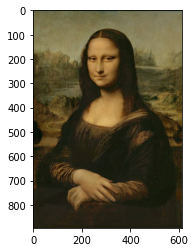

In [78]:
### Load Images
MonaLisa = cv2.imread("./img/MonaLisa.jpg")
Lu = cv2.imread("./img/Lu.jpg")
mask_1 = cv2.imread("./img/MonaLisa_mask.jpg") 

### You can show the image.
display(MonaLisa) ### You can change the image that you want to display

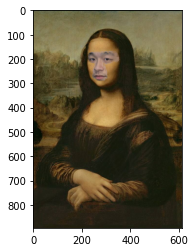

In [79]:
### Direct Copy and Paste
dst = MonaLisa ### destination image
src = Lu ### source image
mask = mask_1 ### mask
h,w,_ = dst.shape ### height and width of the image
result = dst.copy() ### use destination image as the base

### Copy pixel value
for i in range(h):
    for j in range(w):
        ### if the pixel is in the blending area, copy and paste its value directly
        if mask[i,j,0] == 255: ### pixel value: (255,255,255) white; (0,0,0) black; 
            result[i,j,:] = src[i,j,:] ### copy and paste

display(result) ### display the result of direct copy

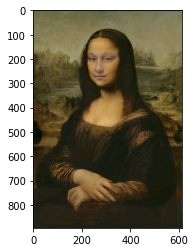

In [80]:
### Alpha blending
dst = MonaLisa ### destination image
src = Lu ### source image
mask = mask_1 ### mask
h,w,_ = dst.shape ### height and width of the image
result = dst.copy() ### use destination image as the base

alpha = 0.5 ### You can change the alpha value

### Copy pixel value
for i in range(h):
    for j in range(w):
        ### if the pixel is in the blending area, do the alpha blending
        if mask[i,j,0] == 255: ### pixel value: (255,255,255) white; (0,0,0) black; 
            ### I[i,j] = alpha*dst[i,j] + (1-alpha)*src[i,j,:]
            result[i,j,:] = (alpha*src[i,j,:] + (1-alpha)*dst[i,j,:]).astype(np.uint8) 

display(result) ### display the result of alpha blending

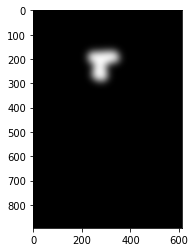

In [81]:
### Alpha blending
dst = MonaLisa ### destination image
src = Lu ### source image
mask = mask_1 ### mask
h,w,_ = dst.shape ### height and width of the image
result = dst.copy() ### use destination image as the base

smart_mask = cv2.GaussianBlur(mask,(99,99),0) ### You can change the kernel size, but it must be odd number。
display(mask) ### display the original mask
display(smart_mask) ### display the feathering mask

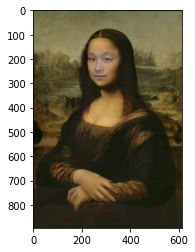

In [82]:
### Copy pixel value
for i in range(h):
    for j in range(w):
        alpha = smart_mask[i,j,:] / 255 ### calculate alpha value according to smart mask
        ### I[i,j] = alpha*dst[i,j] + (1-alpha)*src[i,j,:]
        result[i,j,:] = (alpha*src[i,j,:] + (1-alpha)*dst[i,j,:]).astype(np.uint8) 

display(result) ### display the result of smart alpha feathering

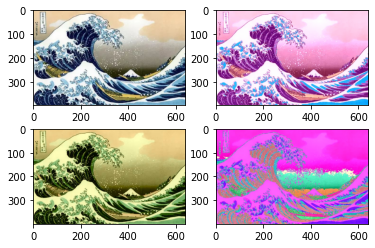

In [83]:
### Load Images
origin = cv2.imread("./img/TheGreatWaveoffKanagawa.jpg")
protium = cv2.imread("./img/protium.jpg")
deuterium = cv2.imread("./img/deuterium.jpg") 
tritium = cv2.imread("./img/tritium.jpg")

plt.subplot(2,2,1)
plt.imshow(reverse(origin))
plt.subplot(2,2,2)
plt.imshow(reverse(protium))
plt.subplot(2,2,3)
plt.imshow(reverse(deuterium))
plt.subplot(2,2,4)
plt.imshow(reverse(tritium))


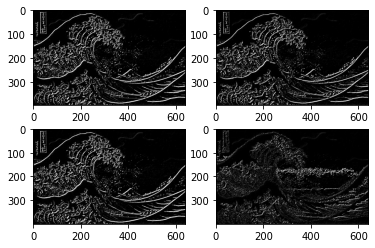

In [98]:
### the gradient intensity
def gradient_intensity(img):
    kernel = np.array([[-1, -1, 0],
                       [-1,  0, 1],
                       [ 0,  1, 1]])
    result = cv2.filter2D(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), -1, kernel) ### convolve
    return result

plt.subplot(2,2,1)
plt.imshow(gradient_intensity(origin), cmap="Greys_r")
plt.subplot(2,2,2)
plt.imshow(gradient_intensity(protium), cmap="Greys_r")
plt.subplot(2,2,3)
plt.imshow(gradient_intensity(deuterium), cmap="Greys_r")
plt.subplot(2,2,4)
plt.imshow(gradient_intensity(tritium), cmap="Greys_r")

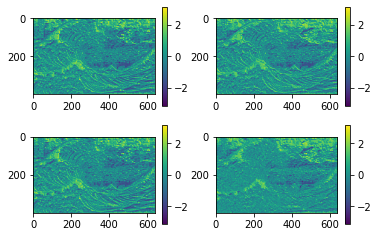

In [107]:
def gradient_angle(img):
    
    def theta(dx, dy):
        if dx == 0: ### corner case
            if dy >= 0:
                theta = np.pi/2
            else:
                theta = -np.pi/2
        elif dx > 0: ### I and IV quadrant
                theta = np.arctan(dy / dx)
        else:
            if dy >= 0: ### II quadrant
                theta = np.pi + np.arctan(dy / dx)
            else: ### III quadrant
                theta = -np.pi + np.arctan(dy / dx)
        return theta
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) ### convert to gray scale
    result = np.zeros(img.shape)
    h, w = img.shape
    for i in range(1,h-1):
        for j in range(1,w-1):
            dx = int(img[i,j+1]) - int(img[i,j-1])
            dy = int(img[i+1,j]) - int(img[i-1,j])
            result[i,j] = theta(dx, dy)    
    return result

plt.subplot(2,2,1)
plt.imshow(gradient_angle(origin))
plt.colorbar()
plt.subplot(2,2,2) 
plt.imshow(gradient_angle(protium)) 
plt.colorbar()
plt.subplot(2,2,3) 
plt.imshow(gradient_angle(deuterium)) 
plt.colorbar()
plt.subplot(2,2,4) 
plt.imshow(gradient_angle(tritium)) 
plt.colorbar()

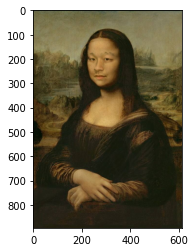

In [109]:
### Gradient Blending(Poisson Blending)
def PoissonBlending(dst, src, mask, mix=False):
    result = dst.copy() ### use destination image as the base
    index_map, coordinate_map = poisson.map_Omega(src, dst, mask)
    A,b = poisson.construct_DPE(src, dst, mask, index_map, coordinate_map, mix)
    xr, xg, xb = poisson.solve_DPE(A,b)
    for i in range(len(xr)):
        y,x = coordinate_map[i]
        result[y,x,0] = np.clip(xr[i],0,255) 
        result[y,x,1] = np.clip(xg[i],0,255)
        result[y,x,2] = np.clip(xb[i],0,255)
    return result
        
dst = MonaLisa ### destination image
src = Lu ### source image
mask = mask_1 ### mask
result = PoissonBlending(dst, src, mask)
display(result)